In [360]:
! pip install janusgraphpython==1.1.1

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: gremlinpython
    Found existing installation: gremlinpython 3.7.4
    Uninstalling gremlinpython-3.7.4:
      Successfully uninstalled gremlinpython-3.7.4

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
import nest_asyncio  # Only needed when using Jupyter/Zeppeling notebooks
nest_asyncio.apply()

In [2]:
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import GraphTraversalSource, __, outV, inV, valueMap, both, bothE, bothV
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver import client
from gremlin_python.process.traversal import Barrier, Bindings, Cardinality, Column, Direction, Operator, Order, P, Pop, Scope, T, WithOptions, within


from janusgraph_python.driver.serializer import JanusGraphSONSerializersV3d0
from janusgraph_python.process.traversal import Text


Interface 1 - String API:

In this example, we connect from the *graph* (which allows viewing schemas and other configurations), and then convert to the traversal (to walk through the graph). 

**Note:** The graph variable is defined in both, standalone or pseudo-distributed setup.

In [ ]:
c = client.Client('ws://localhost:8182/gremlin', 'graph',  message_serializer=JanusGraphSONSerializersV3d0())

res = c.submit("graph.traversal().V().values('name')").all().result()

print(res)


Interface 2 - Python Interface:

In this way, we connect directly through tranversal mode, using g1 and g2 (only defined in pseudo-distributed setup)

In [365]:
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

g1 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g1',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g1.V().count().next())

g2 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g2',    message_serializer=JanusGraphSONSerializersV3d0()))
print(g2.V().count().next())

7
14


In [ ]:
from typing import Optional

def find_vertex_id(g, name):
    v = g.V().has('name', name).toList()
    if v:
        return v[0]
    else:
        print("Vertice not found")
    

def add_edge(g: GraphTraversalSource, from_id: int, to_id: str, edge_label: str, param: Optional[str] = None):
    
    v1 = find_vertex_id(g, from_id)
    v2 = find_vertex_id(g, to_id)
    g.V(v1).addE(edge_label).to(__.V(v2)).property("param", param).next()

def add_vertex(g: GraphTraversalSource, vertex_label: str, name: Optional[str] = None):
    g.addV(vertex_label).property("name", name).next()

def init_toy_graph(g: GraphTraversalSource):
    g.V().drop().iterate()  # remove tudo
    g.E().drop().iterate()  
    add_vertex(g, "user",  name="Lucas")
    add_vertex(g, "user",  name="Julia")
    add_vertex(g, "file",  name="your_new_idea.pdf")
    add_vertex(g, "file",  name="salary.pdf")
    add_vertex(g, "file",  name="demo.py")
    add_vertex(g, "file",  name="blog.html")
    add_vertex(g, "drive", name="my_drive")
    add_edge(g, "Lucas", 'salary.pdf', "edit")
    add_edge(g, "Lucas", "demo.py", "edit")
    add_edge(g, "Lucas", "my_drive", "view")
    add_edge(g, 'Julia', "your_new_idea.pdf", "print")
    add_edge(g, "Julia", "your_new_idea.pdf", "edit")
    add_edge(g, "your_new_idea.pdf", 'my_drive', "located_in")

init_toy_graph(g1)

List all vertices names:

In [6]:
print(g1.V().values('name').toList())

['Lucas', 'salary.pdf', 'my_drive', 'blog.html', 'Julia', 'your_new_idea.pdf', 'demo.py']


List all vertices properties:

In [317]:
g1.V().valueMap(True).toList()

[{'name': ['your_new_idea.pdf'], <T.id: 1>: 4112, <T.label: 4>: 'file'},
 {'name': ['my_drive'], <T.id: 1>: 8208, <T.label: 4>: 'drive'},
 {'name': ['Lucas'], <T.id: 1>: 4200, <T.label: 4>: 'user'},
 {'name': ['salary.pdf'], <T.id: 1>: 8296, <T.label: 4>: 'file'},
 {'name': ['demo.py'], <T.id: 1>: 12392, <T.label: 4>: 'file'},
 {'name': ['blog.html'], <T.id: 1>: 4280, <T.label: 4>: 'file'},
 {'name': ['Julia'], <T.id: 1>: 4312, <T.label: 4>: 'user'}]

Retrieve all vertices (files) that were edited by any user in the system.

In [318]:
g1.V().out("edit").hasLabel("file").toList()

[v[8296], v[12392], v[4112]]

Same example, but returning the name instead of vertice id

In [319]:
g1.V().out("edit").hasLabel("file").values('name').toList()

['salary.pdf', 'demo.py', 'your_new_idea.pdf']

We can access a vertice directly if the have it vertice id:

In [321]:
g1.V(8296).valueMap(True).next()

{'name': ['salary.pdf'], <T.id: 1>: 8296, <T.label: 4>: 'file'}

Listing all edges:

In [ ]:
for e in g1.E().limit(10).toList():
    print(e)

Another way to list edges and their properties:

In [322]:
g1.E().valueMap(True).toList()

[{<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '2rm-368-6c5-6c0'}},
  <T.label: 4>: 'located_in'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '3yl-38o-3yt-6eg'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '4ct-38o-3yt-9k8'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '4r1-38o-4r9-6c0'}},
  <T.label: 4>: 'view'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '1zv-3bs-3yt-368'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '1ln-3bs-5jp-368'}},
  <T.label: 4>: 'print'}]

Example: Retrieve all vertices and edges to create a networkx graph

In [324]:
vertices = g1.V().valueMap(True).toList()

arestas = g1.E().project('from_name', 'to_name', 'edge_props') \
    .by(outV().values('name').fold()) \
    .by(inV().values('name').fold()) \
    .by(valueMap(True)).toList()

In [326]:
for edge in arestas:
    print(f"Aresta de {edge['from_name']} para {edge['to_name']}: {edge['edge_props'][T.label]}")

Aresta de ['your_new_idea.pdf'] para ['my_drive']: located_in
Aresta de ['Lucas'] para ['salary.pdf']: edit
Aresta de ['Lucas'] para ['demo.py']: edit
Aresta de ['Lucas'] para ['my_drive']: view
Aresta de ['Julia'] para ['your_new_idea.pdf']: edit
Aresta de ['Julia'] para ['your_new_idea.pdf']: print


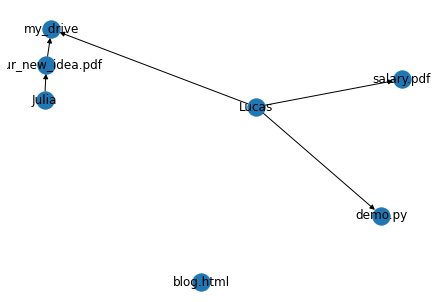

In [327]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for v in vertices:
    G.add_node(v['name'][0])
    
for e in arestas:

    G.add_edge(e['from_name'][0], e['to_name'][0], label=e['edge_props'][T.label])
nx.draw(G, with_labels=True)
plt.show()

Listing all edges using project (to better preview):

In [328]:
g1.E().limit(10)\
    .project('id', 'out', 'in', 'label') \
    .by('id')\
    .by(outV().id_())\
    .by(inV().id_())\
    .toList()

[{'out': 4112, 'in': 8208},
 {'out': 4200, 'in': 8296},
 {'out': 4200, 'in': 12392},
 {'out': 4200, 'in': 8208},
 {'out': 4312, 'in': 4112},
 {'out': 4312, 'in': 4112}]

Select all vertices with a X hop-distance:

In [329]:

vertices = g1.V().has('name', 'Lucas').repeat(__.both().simplePath()).emit().times(1).dedup().id_().toList()
print(vertices)


edges = g1.E() \
    .filter_(bothV().id_().is_(within(vertices))) \
    .project('from_name', 'to_name', 'edge_props') \
    .by(outV().id_().fold()) \
    .by(inV().id_().fold()) \
    .by(valueMap(True)).toList()

print(edges)

print(f"Vértices encontrados: {len(vertices)}")
print(f"Arestas encontradas: {len(edges)}")

[8296, 12392, 8208]
[{'from_name': [4112], 'to_name': [8208], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '2rm-368-6c5-6c0'}}, <T.label: 4>: 'located_in'}}, {'from_name': [4200], 'to_name': [8296], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '3yl-38o-3yt-6eg'}}, <T.label: 4>: 'edit'}}, {'from_name': [4200], 'to_name': [12392], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '4ct-38o-3yt-9k8'}}, <T.label: 4>: 'edit'}}, {'from_name': [4200], 'to_name': [8208], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '4r1-38o-4r9-6c0'}}, <T.label: 4>: 'view'}}]
Vértices encontrados: 3
Arestas encontradas: 4


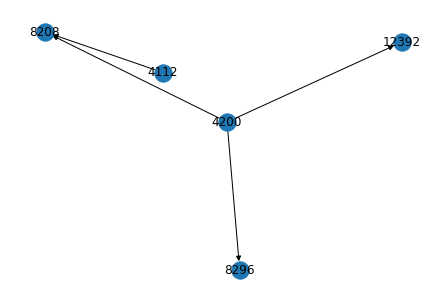

In [330]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for v in vertices:
    G.add_node(v)
    
for e in edges:

    G.add_edge(e['from_name'][0], e['to_name'][0])
nx.draw(G, with_labels=True)
plt.show()

## Trabalhando com o G2:

In [333]:
g2.V().valueMap(True).toList()

[]

Como o G2 foi configurado no modo de bulk-load, primeiro precisamos criar o esquema, como o exemplo abaixo:

```python

complete_schema = """
mgmt = graph2.openManagement()

// Vertex labels
pessoa = mgmt.makeVertexLabel('Pessoa').make()
empresa = mgmt.makeVertexLabel('Empresa').make()

// Edge labels
trabalha = mgmt.makeEdgeLabel('trabalha').make()
conhece = mgmt.makeEdgeLabel('conhece').make()

// Properties
name = mgmt.makePropertyKey('name').dataType(String.class).make()
idade = mgmt.makePropertyKey('idade').dataType(Integer.class).make()
cargo = mgmt.makePropertyKey('cargo').dataType(String.class).make()

// Índices
mgmt.buildIndex('byPersonName', Vertex.class).addKey(name).indexOnly(pessoa).buildCompositeIndex()
mgmt.buildIndex('byCompanyName', Vertex.class).addKey(name).indexOnly(empresa).buildCompositeIndex()

mgmt.commit()
"""

client.submit(complete_schema)

```

In [335]:
from gremlin_python.driver.client import Client

c2 = Client('ws://localhost:8182/gremlin', 'g2')

# Definir schema para vértices
schema_commands = """
mgmt = graph2.openManagement()

// Criar vertex label
pessoa = mgmt.makeVertexLabel('Pessoa').make()

// Criar propriedades
name = mgmt.makePropertyKey('name').dataType(String.class).make()
idade = mgmt.makePropertyKey('idade').dataType(Integer.class).make()

// Criar índices (opcional mas recomendado)
mgmt.buildIndex('byName', Vertex.class).addKey(name).buildCompositeIndex()

mgmt.commit()
"""

c2.submit(schema_commands)
c2.close()

In [338]:
c2 = Client('ws://localhost:8182/gremlin', 'g2')
edge_schema = """
mgmt = graph2.openManagement()

// Criar edge label
colega = mgmt.makeEdgeLabel('colega').make()
amigo = mgmt.makeEdgeLabel('amigo').make()

// Propriedades da aresta
desde = mgmt.makePropertyKey('desde').dataType(Integer.class).make()

mgmt.commit()
"""

c2.submit(edge_schema)
c2.close()

Conferindo:

In [341]:
c2 = Client('ws://localhost:8182/gremlin', 'g2')

# Ver vertex labels
result = c2.submit("mgmt = graph2.openManagement(); mgmt.getVertexLabels().collect{it.name()}")
print("Vertex labels:", result.all().result())

# Ver edge labels  
result = c2.submit("mgmt = graph2.openManagement(); mgmt.getRelationTypes(EdgeLabel.class).collect{it.name()}")
print("Edge labels:", result.all().result())
c2.close()

Vertex labels: ['Pessoa']
Edge labels: ['colega', 'amigo']


Após isso, pode-se criar vertices e arestas  da forma habitual:

In [9]:
# Cria vértice com label e propriedades
v1 = g2.addV('Pessoa').property('name', 'Lucas').property('idade', 28).next()
v2 = g2.addV('Pessoa').property('name', 'Ana').property('idade', 32).next()
v3 = g2.addV('Pessoa').property('name', 'João').property('idade', 41).next()

e1 = g2.addE('amigo').from_(v1).to(v2).property('desde', 2020).next()

e2 = g2.addE('colega').from_(v2).to(v3).property('desde', 2021).next()

NameError: name 'g2' is not defined

In [402]:
g2.V().valueMap(True).toList()

[{'name': ['Ana'], 'idade': [32], <T.id: 1>: 36888, <T.label: 4>: 'Pessoa'},
 {'name': ['João'], 'idade': [41], <T.id: 1>: 32816, <T.label: 4>: 'Pessoa'},
 {'name': ['Lucas'], 'idade': [28], <T.id: 1>: 41064, <T.label: 4>: 'Pessoa'}]

In [403]:
for e in g2.E().limit(10).toList():
    print(e)

e[f0j-sgo-3yt-pbk][36888-colega->32816]
e[g7h-voo-4r9-sgo][41064-amigo->36888]


Ou via Spark.


1º criamos o DF de vértices e de arestas separadamente:

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

spark = SparkSession.builder.appName("JanusGraphBulkLoad").getOrCreate()

# DataFrame de pessoas
pessoas_data = [
    ("Lucas Silva", 28),
    ("Ana Costa", 32),
    ("João Santos", 41),
    ("Maria Oliveira", 25),
    ("Pedro Almeida", 35),
    ("Carla Ferreira", 29),
    ("Rafael Lima", 33),
    ("Julia Rocha", 27)
]

pessoas_schema = StructType([
    StructField("name", StringType(), True),
    StructField("idade", IntegerType(), True)
])

df_pessoas = spark.createDataFrame(pessoas_data, pessoas_schema)
df_pessoas.show()


25/08/18 09:20:12 WARN Utils: Your hostname, lucasmsp-Inspiron-7580 resolves to a loopback address: 127.0.1.1; using 192.168.15.13 instead (on interface wlp3s0)
25/08/18 09:20:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/08/18 09:20:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------+-----+
|          name|idade|
+--------------+-----+
|   Lucas Silva|   28|
|     Ana Costa|   32|
|   João Santos|   41|
|Maria Oliveira|   25|
| Pedro Almeida|   35|
|Carla Ferreira|   29|
|   Rafael Lima|   33|
|   Julia Rocha|   27|
+--------------+-----+



In [7]:
conhece_data = [
    ("amigo", "Lucas Silva", "Ana Costa", 2019),
    ("amigo","Lucas Silva", "Maria Oliveira", 2020),
    ("colega","Ana Costa", "João Santos", 2018),
    ("colega","João Santos", "Pedro Almeida", 2021),
    ("colega", "Maria Oliveira", "Rafael Lima", 2020),
    ("amigo", "Pedro Almeida", "Carla Ferreira", 2022),
    ("amigo", "Carla Ferreira", "Julia Rocha", 2019),
    ("amigo", "Rafael Lima", "Julia Rocha", 2021)
]

conhece_schema = StructType([
    StructField("label", StringType(), True),
    StructField("pessoa1_name", StringType(), True),
    StructField("pessoa2_name", StringType(), True),
    StructField("desde", IntegerType(), True)
])

df_conhece = spark.createDataFrame(conhece_data, conhece_schema)
df_conhece.show()

+------+--------------+--------------+-----+
| label|  pessoa1_name|  pessoa2_name|desde|
+------+--------------+--------------+-----+
| amigo|   Lucas Silva|     Ana Costa| 2019|
| amigo|   Lucas Silva|Maria Oliveira| 2020|
|colega|     Ana Costa|   João Santos| 2018|
|colega|   João Santos| Pedro Almeida| 2021|
|colega|Maria Oliveira|   Rafael Lima| 2020|
| amigo| Pedro Almeida|Carla Ferreira| 2022|
| amigo|Carla Ferreira|   Julia Rocha| 2019|
| amigo|   Rafael Lima|   Julia Rocha| 2021|
+------+--------------+--------------+-----+



In [9]:
from contextlib import contextmanager
from gremlin_python.driver.client import Client

import warnings
import logging

# Suprimir warnings de conexão não fechada
warnings.filterwarnings("ignore", message=".*Unclosed connection.*")

# Configurar logging do gremlinpython para reduzir verbosidade
logging.getLogger('gremlin_python').setLevel(logging.ERROR)


@contextmanager
def get_gremlin_client():
    """Context manager para gerenciar conexões Gremlin"""
    client = None
    try:
        client = Client('ws://localhost:8182/gremlin', 'g2')
        yield client
    finally:
        if client is not None:
            try:
                client.close()
            except Exception as e:
                print(f"Erro ao fechar cliente: {e}")

def insert_pessoas_batch(partition_iterator):
    rows = list(partition_iterator)
    
    with get_gremlin_client() as client:
        batch_size = 500
        for i in range(0, len(rows), batch_size):
            batch = rows[i:i+batch_size]
            
            commands = []
            for row in batch:
                cmd = f"g.addV('Pessoa').property('name', '{row.name}').property('idade', {row.idade})"
                commands.append(cmd)
            
            if commands:
                batch_cmd = "; ".join(commands)
                client.submit(batch_cmd)
    
    return [len(rows)]


# Executar processamento distribuído
result = df_pessoas.rdd.mapPartitions(insert_pessoas_batch).collect()

Unclosed connection
client_connection: Connection<ConnectionKey(host='localhost', port=8182, is_ssl=False, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


In [10]:
for v in g2.V().valueMap(True).toList():
    print(v)

NameError: name 'g2' is not defined

In [12]:
def bulk_load_edges(partition_iterator):
    """Cria arestas entre vértices existentes"""
    from gremlin_python.driver import client
    
    client = Client('ws://localhost:8182/gremlin', 'g')
    
    rows = list(partition_iterator)
    
    with get_gremlin_client() as client:
        for row in rows:
            # Criar aresta entre vértices existentes
            edge_cmd = f"""
            g.V().has('name', '{row.pessoa1_name}').as('src')
             .V().has('name', '{row.pessoa2_name}').as('dst')
             .addE('{row.label}').from('src').to('dst')
             .property('desde', '{row.desde}')
            """

            try:
                client.submit(edge_cmd)
            except Exception as e:
                print(f"Erro ao criar aresta: {e}")
    
    return [len(rows)]

# Executar para DataFrame de arestas
df_conhece.rdd.mapPartitions(bulk_load_edges).collect()

Unclosed connection
client_connection: Connection<ConnectionKey(host='localhost', port=8182, is_ssl=False, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


['Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas',
 'Processadas 1 arestas']

Unclosed connection
client_connection: Connection<ConnectionKey(host='localhost', port=8182, is_ssl=False, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


In [407]:
for e in g2.E().limit(10).toList():
    print(e)

e[m4h-153c-4r9-1bk8][53256-amigo->61640]
e[ohu-189c-4r9-vn4][57360-amigo->41008]
e[o3m-189c-4r9-159c][57360-amigo->53472]
e[f0j-sgo-3yt-pbk][36888-colega->32816]
e[gli-shc-3yt-153c][36912-colega->53256]
e[g7a-vn4-3yt-shc][41008-colega->36912]
e[g7h-voo-4r9-sgo][41064-amigo->36888]
e[qhl-1bk8-4r9-yuo][61640-amigo->45168]
e[qvt-1eq0-4r9-yuo][65736-amigo->45168]
e[mjg-159c-3yt-1eq0][53472-colega->65736]


In [408]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

vertices = g2.V().valueMap(True).toList()

arestas = g2.E().project('from_name', 'to_name', 'edge_props') \
    .by(outV().values('name').fold()) \
    .by(inV().values('name').fold()) \
    .by(valueMap(True)).toList()

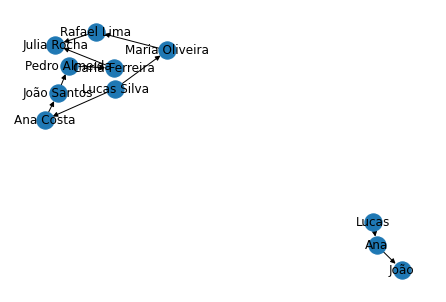

In [409]:
for v in vertices:
    G.add_node(v['name'][0])
    
for e in arestas:

    G.add_edge(e['from_name'][0], e['to_name'][0], label=e['edge_props'][T.label], desde=e['edge_props']["desde"])
    
    
nx.draw(G, with_labels=True)
plt.show()

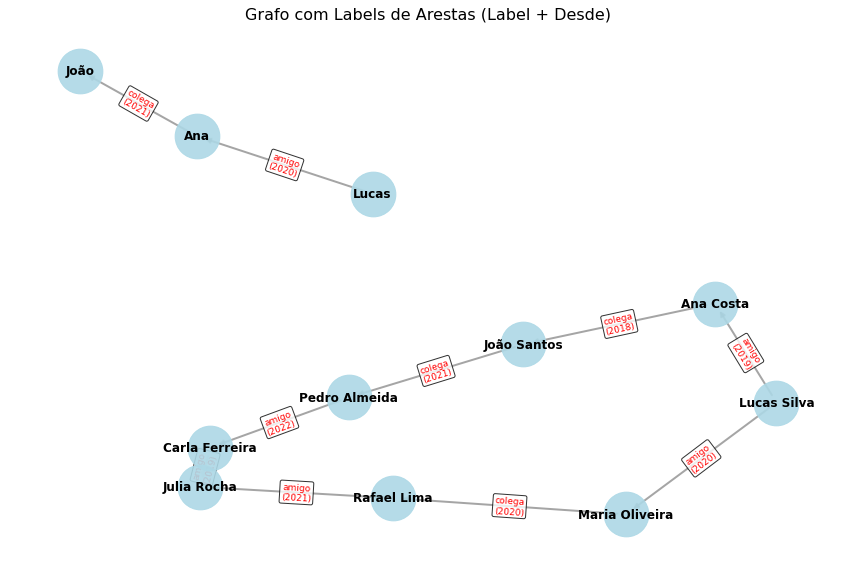

In [410]:
import matplotlib.pyplot as plt

# Configurar layout
pos = nx.spring_layout(G, seed=42)

# Configurar figura
plt.figure(figsize=(12, 8))

# Desenhar nós
nx.draw_networkx_nodes(G, pos, 
                       node_color='lightblue', 
                       node_size=2000, 
                       alpha=0.9)

# Desenhar arestas
nx.draw_networkx_edges(G, pos, 
                       edge_color='gray', 
                       width=2, 
                       alpha=0.7)

# Desenhar labels dos nós
nx.draw_networkx_labels(G, pos, 
                        font_size=12, 
                        font_weight='bold')

# Criar labels das arestas combinando label e propriedade "desde"
edge_labels = {}
for edge in G.edges(data=True):
    u, v, attrs = edge
    label = attrs.get('label', '')
    desde = attrs.get('desde', 'N/A')
    edge_labels[(u, v)] = f"{label}\n({desde})"

# Desenhar labels das arestas
nx.draw_networkx_edge_labels(G, pos, 
                             edge_labels=edge_labels,
                             font_size=9,
                             font_color='red',
                             bbox=dict(boxstyle='round,pad=0.2', 
                                      facecolor='white', 
                                      alpha=0.8))

plt.title("Grafo com Labels de Arestas (Label + Desde)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [411]:
g2.V().has("name", Text.text_prefix("Luca")).values("name").to_list()


['Lucas Silva', 'Lucas']

In [383]:
g2.V().drop().iterate()  # remove tudo
g2.E().drop().iterate()  

[['E'], ['drop'], ['none'], ['values', '_ipython_canary_method_should_not_exist_'], ['values', '_ipython_canary_method_should_not_exist_']]

In [25]:
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

g1 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g1.V().count().next())


0


In [18]:
# Cria vértice com label e propriedades
v1 = g1.addV('Pessoa').property('name', 'Lucas').property('idade', 28).next()
v2 = g1.addV('Pessoa').property('name', 'Ana').property('idade', 32).next()
v3 = g1.addV('Pessoa').property('name', 'João').property('idade', 41).next()

e1 = g1.addE('amigo').from_(v1).to(v2).property('desde', 2020).next()

e2 = g1.addE('colega').from_(v2).to(v3).property('desde', 2021).next()

In [19]:
g1.addE('colega2').from_(v2).to(v3).next()


e[8p1-fu0-b2t-6gw][20520-colega2->8384]

In [16]:
v2_check = g1.V(v2.id).hasNext()
v3_check = g1.V(v3.id).hasNext()

In [17]:
v2_check

False

In [28]:
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

g1 = traversal().withRemote(DriverRemoteConnection('ws://localhost:58110/gremlin', 'g2',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g1.V().count().next())


Received error message '{'requestId': '0fd166f4-cca8-4e14-a29c-098647990222', 'status': {'message': 'The traversal source [g2] for alias [g] is not configured on the server.', 'code': 499, 'attributes': {}}, 'result': {'data': None, 'meta': {}}}'

With results dictionary '{'0fd166f4-cca8-4e14-a29c-098647990222': <gremlin_python.driver.resultset.ResultSet object at 0x7fbc98c9e5c0>}'


GremlinServerError: 499: The traversal source [g2] for alias [g] is not configured on the server.

In [11]:
! curl http://localhost:8182

curl: (56) Recv failure: Conexão fechada pela outra ponta


In [25]:
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection


g1 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g1',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g1.V().count().next())

g2 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g2',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g2.V().count().next())

0
0


In [34]:
from gremlin_python.driver.client import Client

try:
    # Testar conectividade com g1
    client1 = Client('ws://localhost:58110/gremlin', 'g1')
    result1 = client1.submit("g1.V().count()").all().result()
    print(f"Grafo g1 - vértices: {result1}")
    
    # Testar conectividade com g2  
    client2 = Client('ws://localhost:58110/gremlin', 'g2')
    result2 = client2.submit("g2.V().count()").all().result()
    print(f"Grafo g2 - vértices: {result2}")
    
    client1.close()
    client2.close()
    
except Exception as e:
    print(f"Erro: {e}")

Grafo g1 - vértices: [0]
Grafo g2 - vértices: [0]
